# Digit Recognizer 
A fast.ai implementation for the MNIST Digit Recognizer competition on kaggle. https://www.kaggle.com/c/digit-recognizer 

In [1]:
from fastai import *
from fastai.vision import *

Below is a custom `ImageItemList` that allows us to load the kaggle datasets. Essentially, the images are stored as a label plus a pixel array wrapped up in a csv file.

In [2]:
class CustomImageItemList(ImageItemList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1)
        return Image(pil2tensor(img, dtype=np.float32))

    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, header:str='infer', **kwargs)->'ItemList':
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        res.items = df.iloc[:,1:].apply(lambda x: x.values, axis=1).values
        return res

## Training
note: for some reason transforms seem to hurt performance when training the model, looking into this more. Also, found something somewhere that caused me to set `num_workers` equal to zero. Was getting an error and at the end of the day it seems it was pytorch/windows thing and that was the work around.

In [3]:
#tfms = get_transforms(do_flip=False)
data = (CustomImageItemList.from_csv_custom(path='./data', csv_name='train.csv')
                           .random_split_by_pct(.2)
                           .label_from_df(cols='label')
                           #.transform(tfms)
                           .databunch(bs=64, num_workers=0))
                          

In [4]:
learn = create_cnn(data, arch=models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


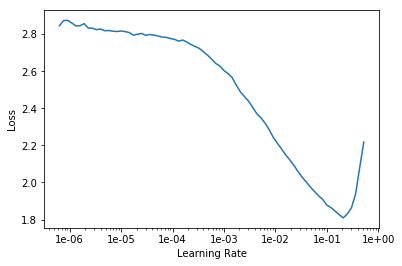

In [5]:
learn.lr_find()
learn.recorder.plot()

In [6]:
lr = 1e-2
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,error_rate
1,0.207268,0.203808,0.060476
2,0.117431,0.142038,0.036667
3,0.059885,0.033020,0.009643
4,0.025400,0.024735,0.006548


In [7]:
learn.save('stage-1')

In [8]:
# tweak all the layers just to see if we can get a little extra performance
learn.unfreeze()
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.043786,0.031265,0.007500


In [9]:
learn.validate()

[0.031265453, tensor(0.0075)]

In [10]:
learn.save('stage-2')

## Interpreting Results

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

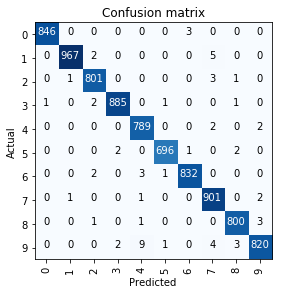

In [12]:
interp.plot_confusion_matrix()

In [13]:
interp.most_confused()

[(9, 4, 9),
 (1, 7, 5),
 (9, 7, 4),
 (0, 6, 3),
 (2, 7, 3),
 (6, 4, 3),
 (8, 9, 3),
 (9, 8, 3),
 (1, 2, 2),
 (3, 2, 2),
 (4, 7, 2),
 (4, 9, 2),
 (5, 3, 2),
 (5, 8, 2),
 (6, 2, 2),
 (7, 9, 2),
 (9, 3, 2)]